In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from exp.nb_02 import *
import torch.nn.functional as F

## Initial setup

In [4]:
x_train, y_train, x_valid, y_valid = get_data()

In [5]:
mpl.rcParams['image.cmap'] = 'gray'

In [6]:
x_train.shape

torch.Size([60000, 784])

In [7]:
n,m = x_train.shape
c = y_train.max() + 1
nh = 50

In [8]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [9]:
model = Model(m,nh,10)

In [10]:
pred = model(x_train)
pred.shape

torch.Size([60000, 10])

In [11]:
def log_softmax(x): return (x.exp() / (x.exp().sum(-1, keepdim=True))).log()

In [12]:
sm_pred = log_softmax(pred)
sm_pred.shape

torch.Size([60000, 10])

In [13]:
def log_softmax2(x): return x - x.exp().sum(-1, keepdim=True).log()

In [14]:
sm_pred2 = log_softmax2(pred)
sm_pred2.shape

torch.Size([60000, 10])

In [15]:
test_near(sm_pred, sm_pred2) #fails for some reason; numbers seem to be near

In [16]:
y_train[:5]

tensor([4, 4, 4, 4, 4])

In [17]:
pred.max(-1)[0].shape

torch.Size([60000])

In [18]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

In [19]:
logsumexp(pred).shape

torch.Size([60000])

In [20]:
test_near(logsumexp(pred), pred.logsumexp(-1))

In [21]:
def log_softmax(pred): return pred - pred.logsumexp(-1, keepdim=True)

In [22]:
pred.shape, y_train.shape

(torch.Size([60000, 10]), torch.Size([60000]))

In [23]:
def nll(pred, target): return -pred[range(pred.shape[0]), target].mean()

In [24]:
loss = nll(log_softmax(pred), y_train)
loss

tensor(2.3064, grad_fn=<NegBackward>)

In [25]:
test_near(nll(log_softmax(pred), y_train), loss)

In [26]:
test_near(F.nll_loss(F.log_softmax(pred, -1),y_train), loss)

In [27]:
test_near(F.cross_entropy(pred, y_train), loss)

# Basic training loop

In [28]:
loss_func = F.cross_entropy

In [29]:
def accuracy(pred, yb): return (pred.argmax(-1) == yb).float().mean()

In [30]:
bs = 64

In [31]:
xb = x_train[:bs]
preds = model(xb)
preds.shape

torch.Size([64, 10])

In [36]:
preds[0]

tensor([ 0.1217,  0.1100,  0.0014,  0.1408, -0.1076,  0.1341,  0.0336,  0.0975,
         0.1190, -0.1265], grad_fn=<SelectBackward>)

In [37]:
yb = y_train[:bs]

In [38]:
loss_func(preds, yb)

tensor(2.4674, grad_fn=<NllLossBackward>)

In [39]:
accuracy(preds, yb)

tensor(0.)

In [40]:
lr = 0.5
epochs = 1

In [41]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias -= l.bias.grad * lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [42]:
def loss_and_accuracy(model=None, xb=xb, yb=yb):
    if model is None: model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return loss_func(model(xb) ,yb), accuracy(model(xb), yb)

In [44]:
loss_and_accuracy(model)

(tensor(0.0014, grad_fn=<NllLossBackward>), tensor(1.))

# Using parameters and optim

In [45]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __call__(self, x): return self.l2(F.relu(self.l1(x)))

In [46]:
nh

50

In [47]:
m

784

In [56]:
model = Model(m,nh,10)

In [57]:
for name,l in model.named_children(): print(f'{name}: {l}')

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)


In [58]:
model

Model(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
)

In [59]:
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [60]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()

In [61]:
loss_and_accuracy(model)

(tensor(2.3928, grad_fn=<NllLossBackward>), tensor(0.))

In [62]:
fit()

In [63]:
loss_and_accuracy(model)

(tensor(0.0014, grad_fn=<NllLossBackward>), tensor(1.))

In [64]:
class DummyModule():
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        
    def __setattr__(self, k, v):
        if not k.startswith('_'): self._modules[k] = v
        super().__setattr__(k,v)
    
    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values():
            for p in l.parameters(): yield p

In [65]:
mdl = DummyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [66]:
mdl.l1

Linear(in_features=784, out_features=50, bias=True)

In [67]:
[p.shape for p in mdl.parameters()]

[torch.Size([50, 784]),
 torch.Size([50]),
 torch.Size([10, 50]),
 torch.Size([10])]

## Registering modules

In [68]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [69]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i, l in enumerate(self.layers): self.add_module(f'layer_{i}', l)
            
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [70]:
model = Model(layers)

In [71]:
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

## nn.Modulelist

In [72]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [73]:
model = SequentialModel(layers)

In [74]:
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [75]:
loss_and_accuracy(model)

(tensor(2.1999, grad_fn=<NllLossBackward>), tensor(0.))

In [76]:
fit()
loss_and_accuracy(model)

(tensor(0.0015, grad_fn=<NllLossBackward>), tensor(1.))

## nn.Sequential

In [77]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [78]:
loss_and_accuracy(model)

(tensor(2.2738, grad_fn=<NllLossBackward>), tensor(0.))

In [79]:
fit()
loss_and_accuracy(model)

(tensor(0.0016, grad_fn=<NllLossBackward>), tensor(1.))

In [80]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

## optim

In [81]:
class Optimizer():
    def __init__(self, params, lr=0.5):
        self.params = list(params)
        self.lr = lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= self.lr * p.grad
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [82]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [83]:
opt = Optimizer(model.parameters())

In [84]:
loss_and_accuracy(model)

(tensor(2.3575, grad_fn=<NllLossBackward>), tensor(0.))

In [85]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [87]:
loss_and_accuracy(model)

(tensor(0.0014, grad_fn=<NllLossBackward>), tensor(1.))

In [88]:
from torch import optim

In [267]:
def get_model():
    "return model and optimizer"
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.Adam(model.parameters(), lr=0.1)

In [90]:
lr

0.5

In [91]:
model, opt = get_model()

In [92]:
loss_and_accuracy(model, xb, yb)

(tensor(2.2088, grad_fn=<NllLossBackward>), tensor(0.))

In [93]:
for epoch in range(epochs):
    for i in range((n-1)//bs + 1):
        start_i = i*bs
        end_i = start_i+bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

In [94]:
loss_and_accuracy(model, xb, yb)

(tensor(0.0015, grad_fn=<NllLossBackward>), tensor(1.))

## Dataset

In [95]:
class Dataset():
    def __init__(self, x, y): self.x, self.y = x, y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

In [96]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

In [97]:
len(train_ds)

60000

In [98]:
xb,yb = train_ds[0:5]
assert xb.shape == (5,28*28)
assert yb.shape == (5,)

In [99]:
model, opt = get_model()

In [100]:
loss_and_accuracy(model, xb, yb)

(tensor(2.3650, grad_fn=<NllLossBackward>), tensor(0.))

In [101]:
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

In [102]:
loss_and_accuracy(model, xb, yb)

(tensor(0.0014, grad_fn=<NllLossBackward>), tensor(1.))

## DataLoader

In [103]:
class DataLoader():
    def __init__(self, ds, bs): self.ds, self.bs = ds, bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [104]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [105]:
xb, yb = next(iter(train_dl))
assert xb.shape == (bs,28*28)
assert yb.shape == (bs,)

tensor(4)

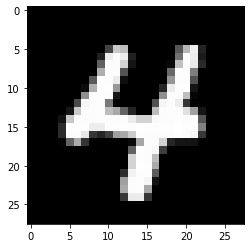

In [106]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [111]:
model, opt = get_model()
loss_and_accuracy(model, xb, yb)

(tensor(2.3657, grad_fn=<NllLossBackward>), tensor(0.))

In [272]:
def fit():
    for epoch in range(epochs):
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

In [113]:
fit()
loss_and_accuracy(model, xb, yb)

(tensor(0.0015, grad_fn=<NllLossBackward>), tensor(1.))

## Random Sampling

In [114]:
class Sampler():
    def __init__(self, ds, bs, shuffle=False):
        self.n, self.bs, self.shuffle = len(ds), bs, shuffle
        
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [115]:
small_ds = Dataset(*train_ds[:10])

In [116]:
s = Sampler(small_ds, 3, False)
[o for o in s]

[tensor([0, 1, 2]), tensor([3, 4, 5]), tensor([6, 7, 8]), tensor([9])]

In [117]:
s = Sampler(small_ds, 3, True)
[o for o in s]

[tensor([7, 6, 2]), tensor([9, 4, 3]), tensor([5, 0, 1]), tensor([8])]

In [118]:
def collate(b):
    xs, ys = zip(*b)
    return torch.stack(xs), torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds, self.sampler, self.collate_fn = ds, sampler, collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [119]:
train_samp = Sampler(train_ds, bs, True)
valid_samp = Sampler(valid_ds, bs, False)

In [120]:
train_dl = DataLoader(train_ds, sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, sampler=valid_samp, collate_fn=collate)

tensor(4)

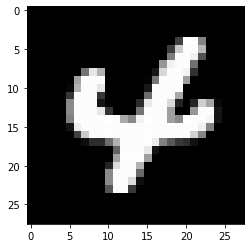

In [148]:
xb, yb = next(iter(valid_dl))
assert xb.shape == (bs,28*28)
assert yb.shape ==(bs,)
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(8)

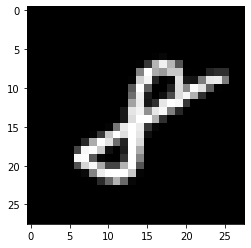

In [122]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

tensor(0)

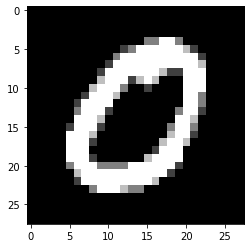

In [131]:
xb,yb = next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [149]:
yb

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [268]:
get_model??

Signature: get_model()
Source:   
def get_model():
    "return model and optimizer"
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.Adam(model.parameters(), lr=0.1)
File:      ~/repo/fastai-course-v3/nbs/dl2/selfmade/<ipython-input-267-95a6ce4c3362>
Type:      function


In [269]:
model,opt = get_model()

In [214]:
# for some reason the default optimizer SGD with lr=0.5 doesnt work anymore after the batch sampling; no idea why

In [270]:
loss_and_accuracy(model, x_train, y_train)

(tensor(2.3046, grad_fn=<NllLossBackward>), tensor(0.0992))

In [273]:
fit()
loss_and_accuracy(model, x_train, y_train)

(tensor(0.2426, grad_fn=<NllLossBackward>), tensor(0.9262))

In [274]:
loss_and_accuracy(model, x_valid, y_valid)

(tensor(0.2428, grad_fn=<NllLossBackward>), tensor(0.9263))

## Pytorch DataLoader

In [275]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [276]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

In [277]:
xb.shape

torch.Size([64, 784])

In [278]:
yb.shape

torch.Size([64])

In [279]:
model, _ = get_model()
opt = optim.Adam(model.parameters(), 0.1)
print(loss_func(model(xb), yb), accuracy(model(xb), yb))
fit()

tensor(2.2637, grad_fn=<NllLossBackward>) tensor(0.)


In [280]:
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0956, grad_fn=<NllLossBackward>), tensor(0.9688))

In [283]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True)
valid_dl = DataLoader(valid_ds, bs, shuffle=False)

In [284]:
model, opt = get_model()
# opt = optim.Adam(model.parameters(), 0.1)
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.0893, grad_fn=<NllLossBackward>), tensor(0.9688))

In [285]:
loss_and_accuracy(model, x_train, y_train)

(tensor(0.2563, grad_fn=<NllLossBackward>), tensor(0.9230))

In [286]:
loss_and_accuracy(model, x_valid, y_valid)

(tensor(0.2550, grad_fn=<NllLossBackward>), tensor(0.9220))

# Validation

In [287]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Handle batchnorm/dropout
        model.train()
        for xb, yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        model.eval()
        with torch.no_grad():
            tot_loss, tot_acc = 0., 0.
            for xb, yb in valid_dl:
                pred = model(xb)
                tot_loss += loss_func(pred, yb)
                tot_acc += accuracy(pred, yb)
                
        nv = len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [288]:
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, bs, shuffle=True, **kwargs), DataLoader(valid_ds, bs*2, **kwargs))

In [289]:
train_dl, valid_dl = get_dls(train_ds, valid_ds, bs)
model, opt = get_model()
loss, acc = fit(5, model, loss_func, opt, train_dl, valid_dl)
loss, acc

0 tensor(0.3097) tensor(0.9079)
1 tensor(0.2844) tensor(0.9179)
2 tensor(0.2605) tensor(0.9260)
3 tensor(0.2648) tensor(0.9259)
4 tensor(0.2830) tensor(0.9221)


(tensor(0.2830), tensor(0.9221))